# Unit 1 - INTRODUCTION TO DIFFUSERS
## This unit consist of basic application of stable diffusion which is to generate images.

The first step is to import huggingface_hub to login to hugginface id in order to use the models, piplenes and datasets provided by huggingface

In [4]:
from huggingface_hub import notebook_login, interpreter_login

interpreter_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token can be pasted using 'Right-Click'.


Token:  ········
Add token as git credential? (Y/n)  Y


Token is valid (permission: write).
Your token has been saved in your configured git credential helpers (manager-core).
Your token has been saved to C:\Users\mkbha\.cache\huggingface\token
Login successful


## Import packages

In [22]:
# numpy package represents array 
import numpy as np
# pytorch is the framework used for transformers
import torch
import torch.nn.functional as F
# matplotlib is used to represent images and graphs
from matplotlib import pyplot as plt
# PIL is used to show and stack images
from PIL import Image

def show_images(x):
    # show_image function will make a grid and convert to PIL for batch of images x
    x = x * 0.5 + 0.5
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    # Stack the images into a line 
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Now that imports are done it is time to use Pipeline of stable diffusion and load the model of mr potato head. In the dreambooth library many other models are also available.

In [3]:
from diffusers import StableDiffusionPipeline

model_id = "sd-dreambooth-library/mr-potato-head"

# Loading the pipeline
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(device)

vae\diffusion_pytorch_model.safetensors not found
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/100 [00:00<?, ?it/s]

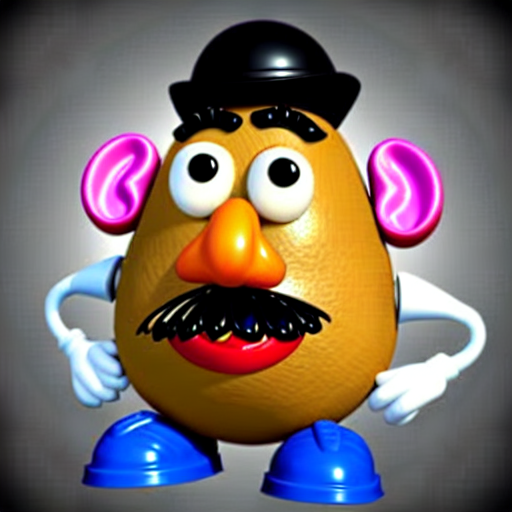

In [5]:
prompt = "Anime version of mr potato head"
image = pipe(prompt, num_inference_steps=100, guidance_scale=8).images[0]
image

As it can be seen that it is not anime like though I have tried changing the guidance scale and inference steps. Guidance scale is the factor which represent how strictly the prompt has to be followed. The reason it is not able to produce anime version may be because the model is not trained on the anime art style.

## Diffusers
The API of huggingface diffuser is divide into three components:
1. $Pipelines$
2. $Models$
3. $Scheduler$

Schedulers are techniques that are used to generate images from noice during inference. It is also used to generate noisy images during training.=

diffusion_pytorch_model.safetensors not found


  0%|          | 0/1000 [00:00<?, ?it/s]

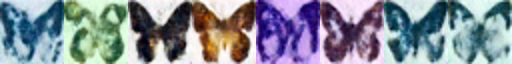

In [7]:
from diffusers import DDPMPipeline

# Loading the butterfly pipeline
butterfly_pipeline = DDPMPipeline.from_pretrained(
    "johnowhitaker/ddpm-butterflies-32px"
).to(device)

# Creating 8 images
images = butterfly_pipeline(batch_size=8).images

# Now printing the images
make_grid(images)

Now it is time to download a dataset on which the diffusers will be implemented. The dataset used is https://www.kaggle.com/datasets/splcher/animefacedataset. It has over 63k anime faces with different size. I have used only first 1,000 faces for this model. The size of images is different from each other so it is necessary to resize them to a certain size.

In [20]:
import torchvision
from datasets import load_dataset
from torchvision import transforms
import os

# saving the path for the dataset
dataset_path= os.path.join("dataset", "images")

# loading the dataset
dataset = load_dataset("imagefolder", data_dir=dataset_path, split='train')

# This is the pixels of the images
image_size = 32

# Batch size, the no. of images feeded to model at once.
batch_size = 64

# For data augmentation
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

# set_transform does not cache data on disk
dataset.set_transform(transform)

# Creating a dataloader form the dataset to serve up transformed images in batch
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

Resolving data files:   0%|          | 0/1000 [00:00<?, ?it/s]

Found cached dataset imagefolder (C:/Users/mkbha/.cache/huggingface/datasets/imagefolder/default-32333280458f5db8/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


X shape: torch.Size([8, 3, 32, 32])


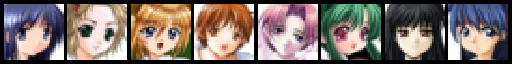

In [23]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8* 64, 64), resample=Image.NEAREST)

## Scheduler

For training, noise is added to the input images. Then these noisy images are feeded to the model. During inference, the model removes the noise to make the prediction. These processes are handled by scheduer.
The noise scheduler determines how much noise has to be added at different timesteps. For this DDPMscheduler is used. (Denoising Diffusion Probabalistic Models).

In [24]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

Noisy X shape torch.Size([8, 3, 32, 32])


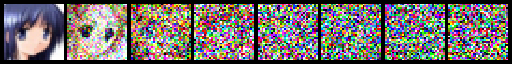

In [29]:
# torch.linspace creates one dimension tensor of size steps with equally distributed values from start to end
timesteps = torch.linspace(start=0, end=999, steps=8).long().to(device)

noise = torch.randn_like(xb)

noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8*64, 64), resample=Image.NEAREST)

## Defining the model

The architecture of diffusion models are based on U-Net model. This means that the model first downsample the image that is decreases the resolutions of the image then upsample the image to the origin resolution.

The model has the input image got through several blocks of ResNet layers, each which halves the image size by 2. Then through sample block upsample it. And there are skip connections which link the features of downsample path to corresponding upsample path.

Diffusers provide UNet2DModel class which creates the desired architecture in PyTorch

In [31]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=image_size, # the target image resolution
    in_channels=3, # channels of input image, 3 for RBG, 1 for B&W
    out_channels=3, # channels for output image
    layers_per_block=2, # Numbers of ResNet layers per UNet block
    block_out_channels=(64, 128, 128, 256), # more channels or parameters or features, used for hyperparameter tuning
    down_block_types=(
        "DownBlock2D", # a regular ResNetdownsampling block
        "DownBlock2D",
        "AttnDownBlock2D", # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D"
    ),
    up_block_types=(
        "AttnUpBlock2D", # a ResNet upsampling block with spatial self-attention
        "AttnUpBlock2D",
        "UpBlock2D", # a regular ResNet upsampling block
        "UpBlock2D",
    ),
)

model.to(device)

UNet2DModel(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(64, 64, ker

In [32]:
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample

model_prediction.shape

torch.Size([8, 3, 32, 32])

## Creating a Training Loop

In [42]:
# Set the noise Scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in range(100):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # Sampling noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0] # batch size
        
        # Sampling a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs, ), device=clean_images.device
        ).long()
        
        # Adding noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
        
        # Getting the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
        
        # Calculating the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())
        
        # Updating the model parameters with the optimizers
        optimizer.step()
        optimizer.zero_grad()
        
    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

d:\AIProjects\StableDiffusionHF\diffusion\lib\site-packages\diffusers\configuration_utils.py:134: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch:5, loss: 0.09698960976675153
Epoch:10, loss: 0.0958164744079113
Epoch:15, loss: 0.08844438847154379
Epoch:20, loss: 0.08234622050076723
Epoch:25, loss: 0.08612354984506965
Epoch:30, loss: 0.08659586450085044
Epoch:35, loss: 0.08093465189449489
Epoch:40, loss: 0.08557623252272606
Epoch:45, loss: 0.0800104457885027
Epoch:50, loss: 0.07875374821014702
Epoch:55, loss: 0.07679301337338984
Epoch:60, loss: 0.07780133141204715
Epoch:65, loss: 0.07243343000300229
Epoch:70, loss: 0.07433891645632684
Epoch:75, loss: 0.07520636706613004
Epoch:80, loss: 0.06746673653833568
Epoch:85, loss: 0.0730418567545712
Epoch:90, loss: 0.07666108757257462
Epoch:95, loss: 0.0722636878490448
Epoch:100, loss: 0.06599554372951388


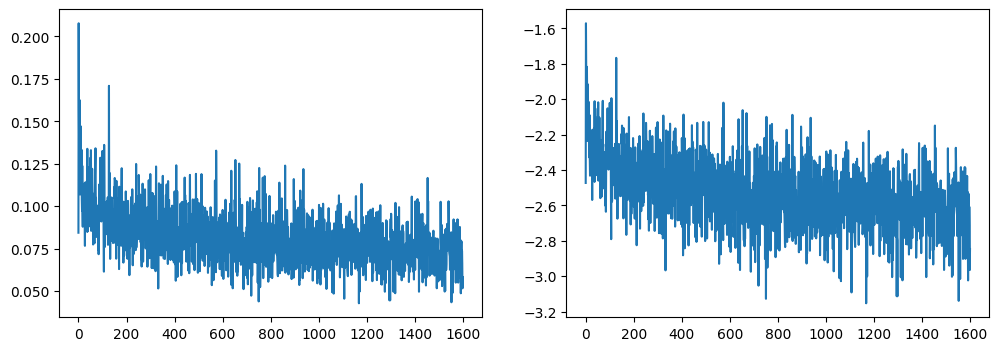

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

## Generating Images

1st method for generating images is by creating a pipeline

In [44]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet = model, scheduler = noise_scheduler)

  0%|          | 0/1000 [00:00<?, ?it/s]

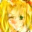

In [45]:
pipeline_output = image_pipe()
pipeline_output.images[0]

In [39]:
image_pipe.save_pretrained("my_pipeline")

2nd option is Writing a Sampling Loop

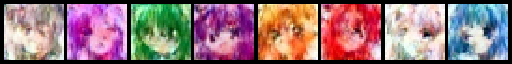

In [41]:
# Prediction of model trained for 30 epochs
# Random starting point (8 random images):
sample = torch.randn(8, 3, 32, 32).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample).resize((8*64, 64), resample=Image.NEAREST)

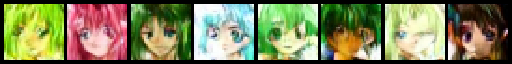

In [46]:
# Prediction of models trained on 130 epochs
# Random starting point (8 random images):
sample = torch.randn(8, 3, 32, 32).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample).resize((8*64, 64), resample=Image.NEAREST)

As we can see, the faces are more recognizable. It seems that the model can be trained more and can be improved also.

## Pushing model to the Hub

In [1]:
from huggingface_hub import get_full_repo_name

model_name = "sd_Anime_Faces_32"
hub_model_id = get_full_repo_name(model_name)
hub_model_id

'Hawk91/sd_Anime_Faces_32'

In [2]:
from huggingface_hub import HfApi, create_repo

create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path="my_pipeline/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(folder_path="my_pipeline/unet", path_in_repo="", repo_id=hub_model_id)
api.upload_file(
    path_or_fileobj="my_pipeline/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

HfHubHTTPError: 409 Client Error: Conflict for url: https://huggingface.co/api/repos/create (Request ID: Root=1-64bbd044-1cff948b1563cf9450123571;d9bd8554-5ea1-4ee8-b8cd-3cbab8c07c0a)

You already created this model repo

In [2]:
from huggingface_hub import ModelCard

content = f"""
---
license: mit
tags:

- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Model Card for Unit 1 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

This model is a diffusion model for unconditional image generation of Anime faces.
github link for repository: https://github.com/mohit-ix/StableDiffusionHF

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub("Hawk91/sd_Anime_Faces_32")

'https://huggingface.co/Hawk91/sd_Anime_Faces_32/blob/main/README.md'